In [1]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from geopy.distance import geodesic
import itertools
from itertools import permutations
from sys import maxsize
import os
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.cluster import KMeans
import random
import io

In [2]:
#input csv file

uploader = widgets.FileUpload(
    accept='.csv',  # Accepted only csv file
    multiple=False  # Single file upload only
)
display(uploader)

def handle_upload(change):
  global df # Declare df as a global variable
  if uploader.value:
    for filename, fileinfo in uploader.value.items():
      df = pd.read_csv(io.BytesIO(fileinfo['content'])) # Define df here
      print(f"Loaded {filename} with {len(df)} rows.")
      display(df.head())

uploader.observe(handle_upload, names='value')

FileUpload(value={}, accept='.csv', description='Upload')

Loaded train.csv with 9 rows.


,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19/03/2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25/03/2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19/03/2022,8:30:00,8:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,5/04/2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26/03/2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [3]:
#input number of drivers
#check the input validation
#if the user input the invalid number the program will crash, it'll be the best to use a loop to validate the input.
while True:
  try:
    num_driver = int(input("Please input the number of drivers: "))
    if num_driver > 0:
      break
    else:
      print('Number of drivers must be positive.')
  except ValueError:
    print("Invalid input. Please enter a valid number for the number of drivers.")

Please input the number of drivers: 2


In [4]:
#input the dept location
while True:
  try:
    depot_lat = float(input("Please input the depot latitude: "))
    depot_lon = float(input("Please input the depot longitude: "))
    break
  except ValueError:
      print("Invalid input. Please enter a valid number for latitude and longitude.")

Please input the depot latitude: 18.643935
Please input the depot longitude: 73.995367


In [5]:
#assign ID
id_cols = ['Delivery_location_latitude', 'Delivery_location_longitude']
if not all(col in df.columns for col in id_cols):
  print(f"Missing columns {', '. join([col for col in id_cols if col not in df.columns])}")
  exit(1)

df['id'] = df[id_cols].ne(df[id_cols].shift()).any(axis=1).cumsum()

# shift column 'id' to first position
first_column = df.pop('id')

# insert column
df.insert(0, 'id', first_column)

In [6]:
# Calculate distance of each delivery point from depot

df['Distance (km)'] = df.apply(lambda row: geodesic((row['Delivery_location_latitude'], row['Delivery_location_longitude']), (depot_lat, depot_lon)).kilometers, axis=1)

In [7]:
#Cluster the delivery points using Kmeans
#This is essential for multi-drivers arrengement.

coords = df[['Delivery_location_latitude', 'Delivery_location_longitude']].values
kmeans = KMeans(n_clusters=num_driver, random_state=42) #produce same cluster for same input data
df['Cluster'] = kmeans.fit_predict(coords)

In [8]:
#Solve TSP by Simulated Annealing (SA)

#Create sub dataframe (group) for each delivery id
for driver_id in range(num_driver):
  driver_group = df[df['Cluster'] == driver_id]
  total_locations = list(zip(driver_group['Delivery_location_latitude'], driver_group['Delivery_location_longitude']))
  location = [(depot_lat, depot_lon)] + total_locations

# Distance Matrix
def distance_matrix(location):
  distance_matrix = []
  for i in range(len(location)):
    row = []
    for j in range (len(location)):
      row.append(geodesic(location[i], location[j]).kilometers)
    distance_matrix.append(row)
  return distance_matrix

dist_matrix = distance_matrix(location)

In [9]:
#Simulated Annealing TSP function
def total_distance(route, dist_matrix):
  return sum(dist_matrix[route[i]][route[i+1]] for i in range(len(route)-1)) + dist_matrix [route[-1]][route[0]]

def simmulated_annealing_tsp(dist_matrix, initial_temp = 10000, cooling_rate = 0.995, stopping_temp = 1e-8, max_iter = 1000): #set up workload
  n = len(dist_matrix)
  current_route = list(range(n))
  current_distance = total_distance(current_route, dist_matrix)
  best_route = list(current_route)
  best_distance = current_distance
  temp = initial_temp

  while temp > stopping_temp:
    for _ in range(max_iter):
      #Swap two citites to get a new route (but not swapping depot at index 0)
      i, j = random.sample(range(1, n), 2)
      new_route = list(current_route)
      new_route[i], new_route[j] = new_route[j], new_route[i]
      new_distance = total_distance(new_route, dist_matrix)
      #Accept new route if it's better or with a probability if it is worse
      if new_distance < current_distance or random.random() < np.exp((current_distance - new_distance) / temp):
        current_route = new_route
        current_distance = new_distance
        if new_distance < best_distance:
          best_route = new_route
          best_distance = new_distance
    temp *= cooling_rate
  return best_route, best_distance

In [10]:
#Main loop for each driver/cluster
for driver_id in range(num_driver):
  driver_group = df[df['Cluster'] == driver_id]
  total_locations = list(zip(driver_group['Delivery_location_latitude'], driver_group['Delivery_location_longitude']))
  location = [(depot_lat, depot_lon)] + total_locations #Depot is always first

  # Calculate and assign best_route and min_cost for each driver
  best_route, min_cost = simmulated_annealing_tsp(distance_matrix(location)) # Pass the correct distance matrix here

In [11]:
%pip install matplotlib folium

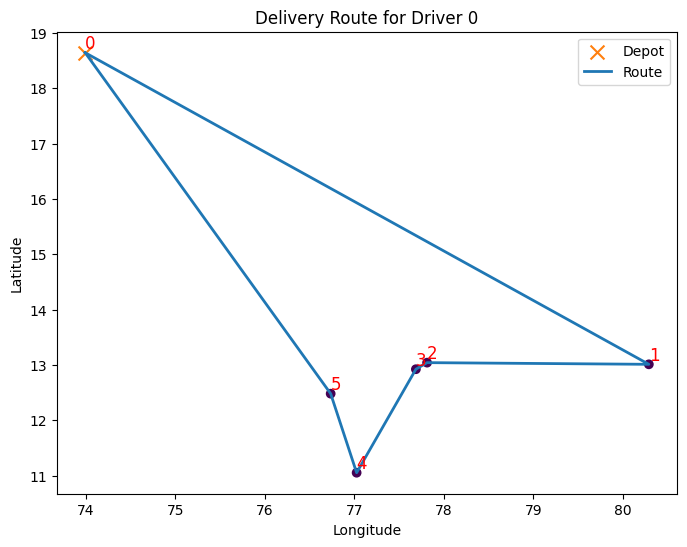

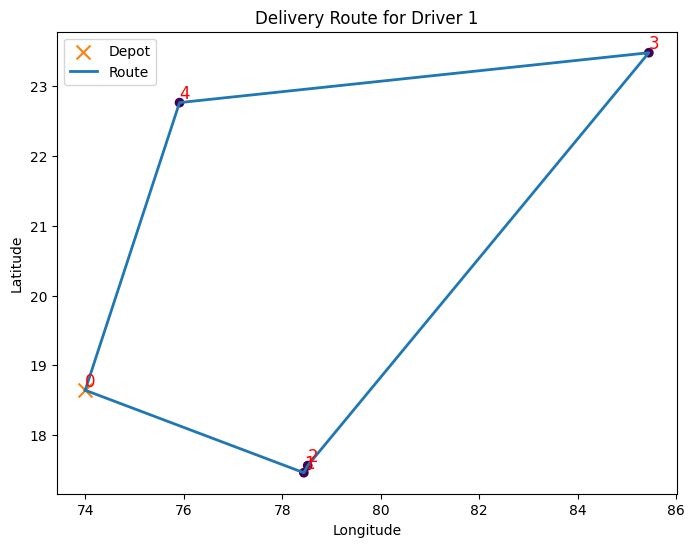

In [12]:
for driver_id in range(num_driver):
    driver_group = df[df['Cluster'] == driver_id]
    total_locations = list(zip(driver_group['Delivery_location_latitude'], driver_group['Delivery_location_longitude']))
    location = [(depot_lat, depot_lon)] + total_locations  # Depot is always first

    best_route, min_cost = simmulated_annealing_tsp(distance_matrix(location))

    # Prepare route coordinates in order
    route_lats = [location[i][0] for i in best_route] + [location[best_route[0]][0]]
    route_lons = [location[i][1] for i in best_route] + [location[best_route[0]][1]]

    plt.figure(figsize=(8, 6))
    plt.scatter(driver_group['Delivery_location_longitude'], driver_group['Delivery_location_latitude'], c=driver_group['Cluster'])
    plt.scatter(depot_lon, depot_lat, color='tab:orange', marker='x', s=100, label='Depot')
    plt.plot(route_lons, route_lats, color='tab:blue', linewidth=2, label='Route')

    # Mark order on plot
    for order, i in enumerate(best_route):
        plt.text(location[i][1], location[i][0], str(order), fontsize=12, ha='left', va='bottom', color='red')

    plt.title(f"Delivery Route for Driver {driver_id}")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

In [13]:
import folium

# Center map on the average location
center_lat = df['Delivery_location_latitude'].mean()
center_lon = df['Delivery_location_longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

for driver_id in range(num_driver):
    driver_group = df[df['Cluster'] == driver_id]
    total_locations = list(zip(driver_group['Delivery_location_latitude'], driver_group['Delivery_location_longitude']))
    location = [(depot_lat, depot_lon)] + total_locations  # Depot is always first

    best_route, min_cost = simmulated_annealing_tsp(distance_matrix(location))
    route_coords = [location[i] for i in best_route] + [location[best_route[0]]]  # Close the loop

    # Draw the route
    folium.PolyLine(route_coords, color=colors[driver_id % len(colors)], weight=4, opacity=0.8).add_to(m)

    # Optionally, add markers for each stop
    for order, (lat, lon) in enumerate(route_coords):
        folium.Marker([lat, lon], popup=f'Stop {order}', icon=folium.Icon(color=colors[driver_id % len(colors)])).add_to(m)

# Save and view the map
m.save('tsp_routes_map.html')
print("Map saved as tsp_routes_map.html")

Map saved as tsp_routes_map.html


In [14]:
# Correct: location = [(lat, lon), ...]
route_coords = [location[i] for i in best_route]  # best_route is the order from TSP

# For Folium:
folium.PolyLine(route_coords, color='red').add_to(m)

m

In [ ]:
  from google.colab import files
  files.download('tsp_routes_map.html')